# Guess Core and use other methods to interpolate

In [1]:
import os, sys
import pickle
from scf_guess_tools import  Backend, load, calculate, guess
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.callbacks import TensorBoard, EarlyStopping
from keras.utils import Sequence
import keras_tuner as kt
import datetime
import random, math
import numpy as np
from pyscf import scf
from pyscf.lib.linalg_helper import eigh
#! Only if there are no cudo GPUs in the system!
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
print("Built with CUDA support?", tf.test.is_built_with_cuda())
print("GPUs detected:", tf.config.list_physical_devices("GPU"))
# List all physical GPUs
gpus = tf.config.list_physical_devices('GPU')
print("GPUs found:", gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2025-06-27 16:25:58.952334: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-27 16:25:59.085527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751034359.132688     919 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751034359.146918     919 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751034359.262581     919 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Built with CUDA support? True
GPUs detected: []
GPUs found: []


2025-06-27 16:26:01.304670: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
import sys, os
from glob import glob
sys.path.append("..")
from BlockMatrix import BlockMatrix
from utils import  plot_mat_comp, flatten_triang_batch, flatten_triang, get_overlap, load_mol, unflatten_triang, density_from_fock, perform_calculation
scripts_path = "../../scripts"
if scripts_path not in sys.path:
    sys.path.append(scripts_path)
from to_cache import density_fock_overlap


In [3]:
train_test_seed = 42
source_path = '../../datasets/QM9/xyz_c7h10o2_sorted/'
all_file_paths = glob(os.path.join(source_path, '*.xyz'))
len(all_file_paths)


6095

In [4]:
def load_cached(file_paths, cache_path, basis, guess="minao", method="dft", functional="b3lypg", backend="pyscf", silent=True):
    def sprint(*args): 
        if not silent:
            print(*args)
    error_list = []
    error_files = []
    focks = []
    overlaps = []
    used_files = []
    reference_densities = []
    for file in file_paths:
        mol_name = os.path.basename(file).strip()
        # sprint(mol_name)
        try: 
            ret = density_fock_overlap(filepath = file,
                                filename = mol_name,
                                method = method,
                                basis = None,
                                functional = functional,
                                guess = guess,
                                backend = backend,
                                cache = cache_path)
            sprint(f"Using: file={file} - mol_name={mol_name} - basis={None} - guess={guess} - method={method} - functional={functional}")
        except Exception as e: 
            error_list.append(e)
            error_files.append(mol_name)
            sprint(f"File {mol_name} error - skipping")
            continue
        if any([r == None for r in ret]): 
            sprint(f"File {mol_name} bad - skipping")
            continue
        focks.append(ret[1].numpy)
        used_files.append(file)
        reference_densities.append(ret[0].numpy)
        overlaps.append(ret[2].numpy)
    sprint(f"Got data for: {len(focks)} - bad / no ret: {len(file_paths) - len(focks) - len(error_list)} - errors: {len(error_list)}")
    sprint(error_files[:5])
    return focks, reference_densities, overlaps, used_files


In [5]:
class RoundRobinLoader(Sequence):
    def __init__(self, file_paths, cache_path, basis, guess, method,
                 functional, backend, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.file_paths  = list(file_paths)
        self.cache_path  = cache_path
        self.basis       = basis
        self.guess       = guess
        self.method      = method
        self.functional  = functional
        self.backend     = backend
        self.batch_size  = batch_size
        self.indexes     = list(range(len(self.file_paths)))
        random.shuffle(self.indexes)

    def __len__(self):
        return math.ceil(len(self.file_paths) / self.batch_size)

    def __getitem__(self, idx):
        batch_idxs  = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_files = [self.file_paths[i] for i in batch_idxs]

        # load a small batch into memory
        focks, dens, ovlps, _ = load_cached(
            batch_files, self.cache_path, self.basis,
            self.guess, self.method, self.functional, self.backend
        )

        X = np.array([flatten_triang(ov) for ov in ovlps])
        # y = np.array([flatten_triang(fk) for fk in focks])# full fock as target!
        y = np.array([np.diag(fk) for fk in focks])

        return X, y

    def on_epoch_end(self):
        random.shuffle(self.indexes)

In [6]:
# ret = load_cached(all_file_paths, "../../datasets/QM9/out/c7h10o2_b3lypg_6-31G(2df,p)_sorted/pyscf", basis="6-31g_2df_p_custom_nwchem.gbs")

In [7]:
from sklearn.model_selection import train_test_split
train_test_seed = 42
cache_path = "../../datasets/QM9/out/c7h10o2_b3lypg_6-31G(2df,p)_sorted/pyscf"
basis = "../../scripts/6-31g_2df_p_custom_nwchem.gbs"
train_files, val_files = train_test_split(all_file_paths, test_size=0.2, random_state=train_test_seed)
val_files, test_files = val_files[:len(val_files)//2], val_files[len(val_files)//2:]

In [8]:
train_loader = RoundRobinLoader(
    file_paths=train_files,
    cache_path=cache_path,
    basis=basis,
    guess="minao",
    method="dft",
    functional="b3lypg",
    backend="pyscf",
    batch_size=32
)
val_loader = RoundRobinLoader(
    file_paths=val_files,
    cache_path=cache_path,
    basis=basis,
    guess="minao",
    method="dft",
    functional="b3lypg",
    backend="pyscf",
    batch_size=32
)
test_loader = RoundRobinLoader(
    file_paths=test_files,
    cache_path=cache_path,
    basis=basis,
    guess="minao",
    method="dft",
    functional="b3lypg",
    backend="pyscf",
    batch_size=32
)

In [9]:
mat_dim = train_loader[0][0].shape
mat_dim

(32, 40470)

In [10]:
# train data stats: 
train_mean = np.mean(train_loader[0][0])
train_std = np.std(train_loader[0][0])
print("Train mean:", train_mean)
print("Train std:", train_std)
print("Train max", np.max(train_loader[0][0]))
print("Train min", np.min(train_loader[0][0]))

Train mean: 0.009665269214460582
Train std: 0.10151510389872595
Train max 1.0000000000000004
Train min -0.6236456371618612


let's try our luck! - no rescaling for now 

In [11]:
import tensorflow as tf
X_sample, y_sample = train_loader[0]
flattened_dim = X_sample.shape[1]
diag_dim      = y_sample.shape[1]
print(diag_dim)

284


In [42]:
def hp_depth(hp):
    inputs_orig = tf.keras.Input(shape=(flattened_dim,))
    x = inputs_orig
    for i in range(hp.Int("n_layers", 1,4)):
        neurons = 512
        dropout_rate = 0.1
        x = tf.keras.layers.Dense(neurons, activation='gelu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(diag_dim)(x)

    basic_model = tf.keras.Model(inputs=inputs_orig, outputs=outputs)

    initial_lr = 0.01
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=100,
        decay_rate=0.96,
        staircase=False
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    basic_model.compile(optimizer=optimizer, loss="mae", metrics=["mse"])
    return basic_model

def hp_model(hp): 
    tf.random.set_seed(42)
    inputs_orig = tf.keras.Input(shape=(flattened_dim,))
    x = inputs_orig
    for i in range(hp.Int("n_layers", 1,4)):
        neurons = hp.Choice(f"neuron_count_{i}", [512,1024])
        dropout_rate = hp.Float(f"dropout_rate_{i}", 0.0, 0.2, step=0.05)
        x = tf.keras.layers.Dense(neurons, activation='gelu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(diag_dim)(x)

    basic_model = tf.keras.Model(inputs=inputs_orig, outputs=outputs)

    initial_lr = 0.01
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=100,
        decay_rate=0.96,
        staircase=False
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    basic_model.compile(optimizer=optimizer, loss="mae", metrics=["mse"])
    return basic_model


In [43]:
class ClearMemory(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        tf.keras.backend.clear_session()
        import gc; gc.collect()

early_stop = EarlyStopping(
    monitor='val_loss',      
    patience=10,
    restore_best_weights=True
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("models/basic_model_6_31G.keras", save_best_only=True)

# First search optimal depth!

In [45]:
tuner_depth = kt.Hyperband(
    hp_depth, 
    objective='val_loss',
    max_epochs=30,
    factor=3,
    directory='keras_tuning',
    project_name='fock_diag_nn_631_tuning_depth'
)
tuner_depth.search(
    train_loader,
    validation_data=val_loader,
    epochs=30,
    batch_size=32,
    callbacks=[tensorboard_callback, checkpoint_callback, early_stop, ClearMemory()],
    verbose=1
)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
2                 |2                 |n_layers
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
  7/153 ━━━━━━━━━━━━━━━━━━━━ 28s 195ms/step - loss: 2.2855 - mse: 11.0312

KeyboardInterrupt: 

In [ ]:
tuner_depth.results_summary(num_trials=5)

# Search optimal other params

In [ ]:
tuner = kt.Hyperband(
    hp_model,
    objective="val_mse",
    max_epochs=30,
    factor=3,
    directory="keras_tuning",
    project_name="fock_diag_nn_631_tuning"
)
tuner.search(
    train_loader,
    validation_data=val_loader,
    epochs=30,
    batch_size=32,
    steps_per_epoch=16,
    validation_steps=4,
    callbacks=[tensorboard_callback, checkpoint_callback, early_stop, ClearMemory()],
    verbose=1
)
# basic_hist = basic_model.fit(train_loader,
#                             validation_data=val_loader,
#                             epochs=50,
#                             batch_size=32,
#                             callbacks=[tensorboard_callback, checkpoint_callback, early_stop],
#                             verbose=1)

In [ ]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
hyperparams = best_trial.hyperparameters.values
print("Best hyperparameters:")
for key, value in hyperparams.items():
    print(f"{key}: {value}")
val_loss_history = best_trial.metrics.get_history("val_loss")
loss_history = best_trial.metrics.get_history("loss")

fresh_model = tuner.hypermodel.build(best_trial.hyperparameters)
# Get all Dropout rates in fresh_model
dropout_rates = [layer.rate for layer in fresh_model.layers if isinstance(layer, tf.keras.layers.Dropout)]
print("Dropout rates in fresh_model:", dropout_rates)

fresh_model.summary()


history = fresh_model.fit(
    train_loader,
    validation_data=test_loader, # validate on test set!
    epochs=50,
    batch_size=32,
    callbacks=[tensorboard_callback, checkpoint_callback, early_stop, ClearMemory()],
    verbose=1
)

In [ ]:
# Plot the training and validation loss
basic_model = fresh_model
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.yscale('log')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.title('Model loss')

In [ ]:
os.makedirs("models", exist_ok=True)
if os.path.exists("models/basic_model_6_31G.keras") and input("Overwrite existing model? (y/n)") == "y":
    os.remove("models/basic_model_6_31G.keras")
    # also save history
    with open("models/basic_model_6_31G_history.pkl", "wb") as f:
        pickle.dump(history.history, f)
    basic_model.save("models/basic_model_6_31G.keras")
    print("Model saved")
else:
    basic_model.save("models/basic_model_6_31G.keras")
    print("Model saved")

In [12]:
# load model
loaded_model = tf.keras.models.load_model("models/basic_model_6_31G.keras")
basic_model = loaded_model

In [13]:
def reconstruct_Fock(diag, ovlp, K = 1.75): 
    """Take diagonal and reconstruct the Fock matrix using GWH
    """
    mat_dim = diag.shape[0]
    out = np.zeros((mat_dim, mat_dim))
    for i in range(mat_dim):
        for j in range(mat_dim):
            if i == j:
                out[i, j] = diag[i]
            else:
                out[i, j] = K * ovlp[i, j] * (diag[i] + diag[j]) / 2
    return out

In [14]:
# predict: 
test_pred_fock_diag = basic_model.predict(test_loader)

 1/20 ━━━━━━━━━━━━━━━━━━━━ 7s 375ms/step

I0000 00:00:1751034373.942507    1129 service.cc:152] XLA service 0x7ee67c007c80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751034373.942556    1129 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-06-27 16:26:13.963502: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751034374.070224    1129 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step


# Comparison diag error with minao

In [15]:
def get_fock_minao_guess(mol):
    mf = scf.RHF(mol)
    D0 = mf.get_init_guess(mol, key='minao')
    return mf.get_fock(dm=D0)

In [16]:
rmse_minao, rmse_pred = [], []
for i, (file, pred) in enumerate(zip(test_loader.file_paths, test_pred_fock_diag)):
    try:
        test_mol = load(file, symmetry=False, basis = basis, backend=Backend.PY)
        ref_diag = test_loader[i//32][1][i % 32]
        minao_pred_fock = np.diag(get_fock_minao_guess(test_mol.native))
        rmse_minao.append(np.sqrt(np.mean((minao_pred_fock - ref_diag) ** 2)))
        rmse_pred.append(np.sqrt(np.mean((pred - ref_diag) ** 2)))
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue
    rmse_minao_mean, rmse_pred_mean = np.mean(rmse_minao), np.mean(rmse_pred)
    rmse_minao_std, rmse_pred_std = np.std(rmse_minao), np.std(rmse_pred)
    print(f"RMSE MINAO: {rmse_minao_mean:.4f} ± {rmse_minao_std:.4f}")
    print(f"RMSE Pred: {rmse_pred_mean:.4f} ± {rmse_pred_std:.4f}")
    print(i)
    if i > 50: 
        break

rmse_minao_mean, rmse_pred_mean = np.mean(rmse_minao), np.mean(rmse_pred)
rmse_minao_std, rmse_pred_std = np.std(rmse_minao), np.std(rmse_pred)
print(f"RMSE MINAO: {rmse_minao_mean:.4f} ± {rmse_minao_std:.4f}")
print(f"RMSE Pred: {rmse_pred_mean:.4f} ± {rmse_pred_std:.4f}")


RMSE MINAO: 0.3589 ± 0.0000
RMSE Pred: 0.0941 ± 0.0000
0
RMSE MINAO: 0.3503 ± 0.0086
RMSE Pred: 0.0863 ± 0.0077
1


KeyboardInterrupt: 

# Full matrix comparision

File path: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_062867.xyz
../../scripts/6-31g_2df_p_custom_nwchem.gbs


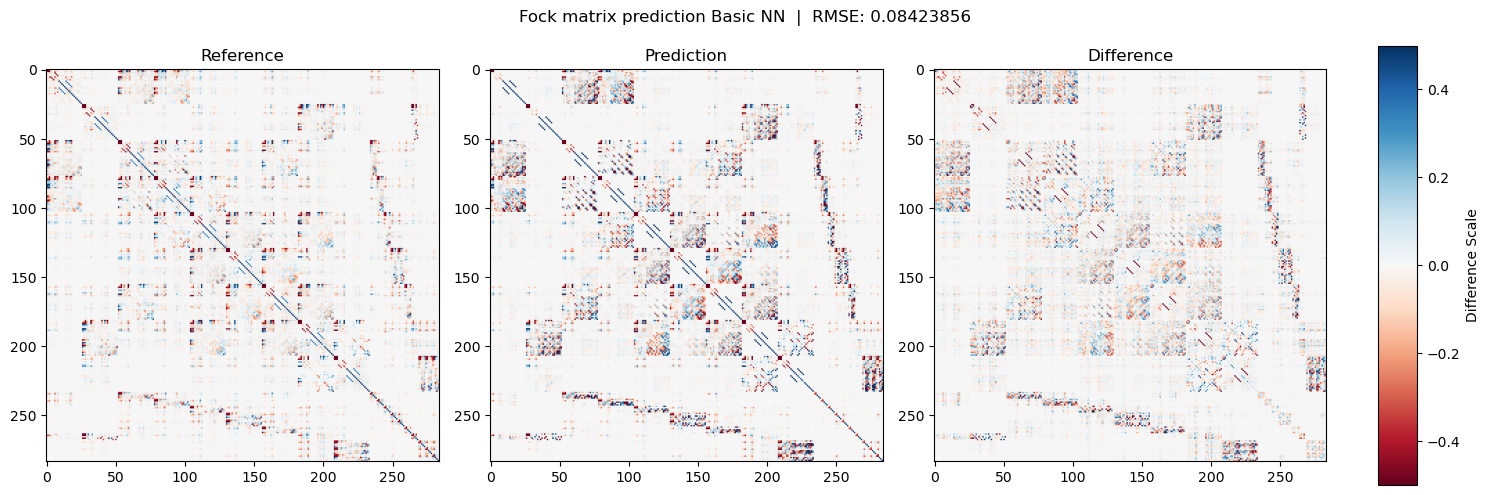

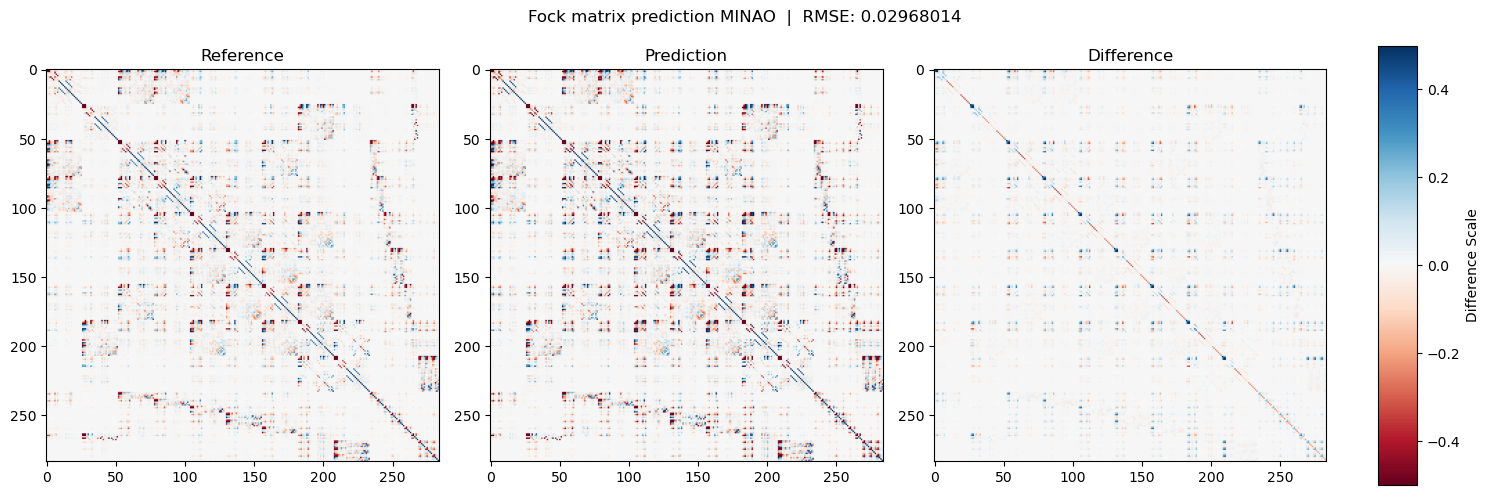

In [17]:
# example comparison: 
rand_test_sample = np.random.randint(0, len(test_loader.file_paths) - 1)
# compare with hückel and minao
file_path = test_loader.file_paths[rand_test_sample]
print("File path:", file_path)
print(basis)
test_mol = load(file_path, symmetry=False, basis = basis, backend=Backend.PY)
focks_ref, dens_ref, ovlps_ref, _ = load_cached(
    [file_path],
    cache_path,
    None,
)
ground_truth_fock    = focks_ref[0]
ground_truth_density = dens_ref[0]
S_test_mol                    = ovlps_ref[0]

minao_guess_fock = get_fock_minao_guess(test_mol.native)
minao_guess_density = guess(test_mol, method="dft", basis=basis, scheme="minao").density().numpy

pred_flat_diag = test_pred_fock_diag[rand_test_sample]
pred_fock      = reconstruct_Fock(pred_flat_diag, S_test_mol)

nelec = test_mol.native.nelectron//2
pred_density_example = density_from_fock(pred_fock, S_test_mol, nelec)

#save stuff for nice thesis plotting
import pickle
plot_path = "../../latex/scripts/mlp_further_trials/plot_data/minao_mlp_comp_data.pkl"
with open(plot_path, "wb") as f:
    pickle.dump({
        "file": file_path,
        "ground_truth_fock": ground_truth_fock,
        "pred_fock": pred_fock,
        "minao_guess_fock": minao_guess_fock,
        "minao_guess_density": minao_guess_density,
        "ground_truth_density": ground_truth_density,
        "pred_density": pred_density_example,
        "S_test_mol": S_test_mol
    }, f)

plot_mat_comp(ground_truth_fock, pred_fock, title="Fock matrix prediction Basic NN", vmax=0.5)
plot_mat_comp(ground_truth_fock, minao_guess_fock, title="Fock matrix prediction MINAO", vmax=0.5)

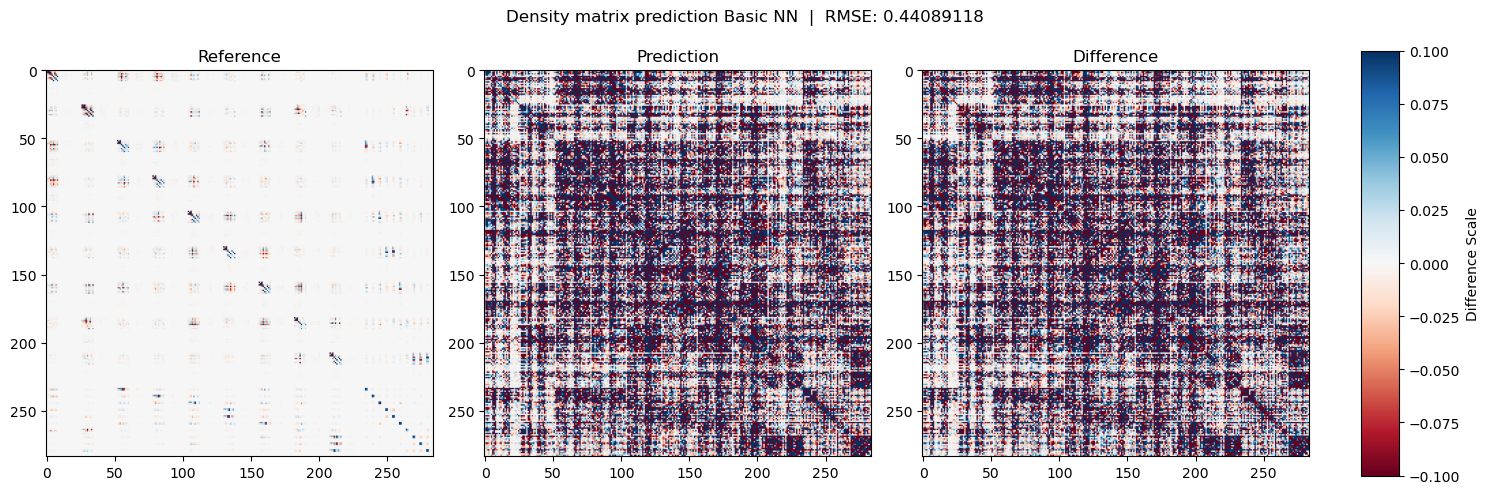

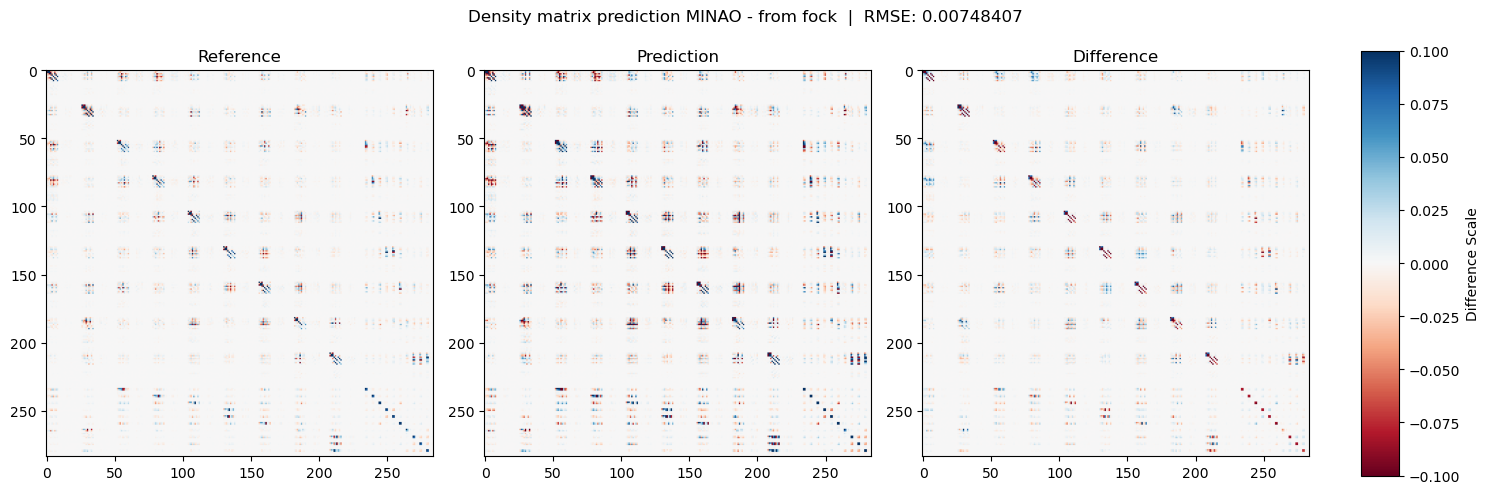

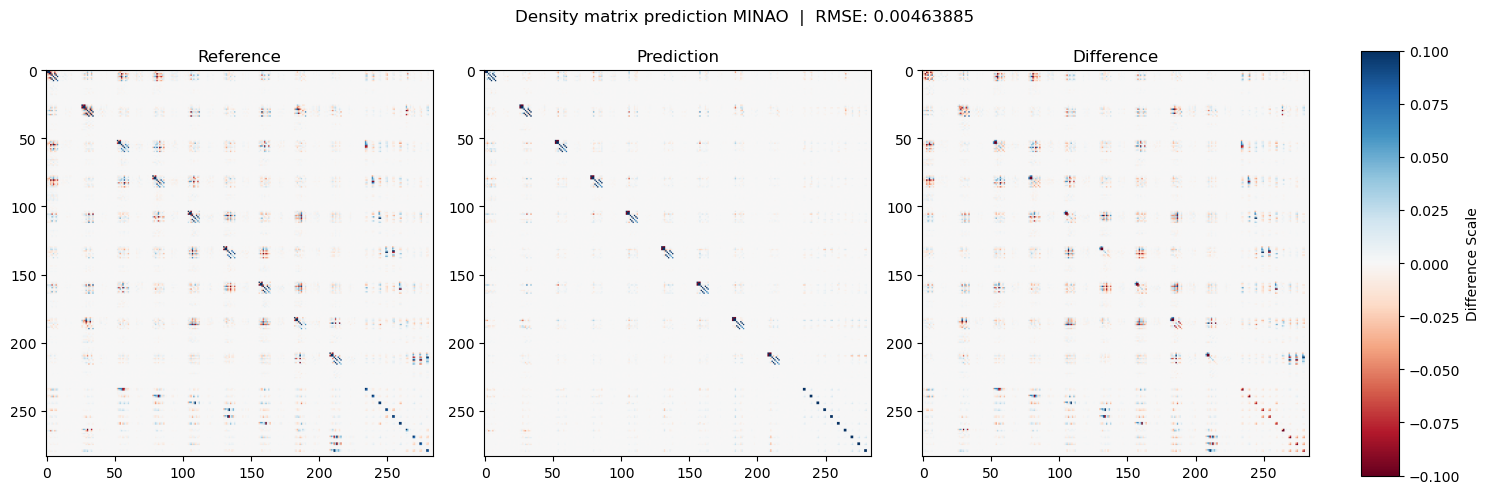

In [18]:
density_from_fock_minao = density_from_fock(minao_guess_fock, S_test_mol, test_mol.native.nelectron//2)
plot_mat_comp(ground_truth_density, pred_density_example, title="Density matrix prediction Basic NN", vmax=0.1)
plot_mat_comp(ground_truth_density, density_from_fock_minao, title="Density matrix prediction MINAO - from fock", vmax=0.1)
plot_mat_comp(ground_truth_density, minao_guess_density, title="Density matrix prediction MINAO", vmax=0.1)

# Small benchmark iterations!

In [19]:
samples = 5

In [ ]:
# test sim
iterations_minao = []
for file in test_loader.file_paths[:samples]:
    print("File:", file)
    cycles = perform_calculation(file, "minao", method="dft", functional="b3lypg", basis_set=basis)["cycles"]
    print("Iterations: ", cycles)
    iterations_minao.append(cycles)

File: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_108760.xyz
converged SCF energy = -423.241566906407
Iterations:  11
File: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_120428.xyz
converged SCF energy = -423.202523802833
Iterations:  11
File: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_060893.xyz
converged SCF energy = -423.130726201391
Iterations:  11
File: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_101049.xyz
converged SCF energy = -423.10722429573
Iterations:  11
File: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_063545.xyz
converged SCF energy = -423.111474999807
Iterations:  10


In [28]:
iterations_nn = []
for file in test_loader.file_paths[:samples]:
    print("File:", file)
    cycles = perform_calculation(file, pred_density_example, method="dft", functional="b3lypg", basis_set=basis)["cycles"]
    print("Iterations: ", cycles)
    iterations_nn.append(cycles)

File: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_108760.xyz
converged SCF energy = -423.241566906789
Iterations:  20
File: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_120428.xyz
converged SCF energy = -423.202523803191
Iterations:  21
File: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_060893.xyz
converged SCF energy = -423.130726201587
Iterations:  20
File: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_101049.xyz
converged SCF energy = -423.107224296134
Iterations:  20
File: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_063545.xyz
converged SCF energy = -423.111475000126
Iterations:  18


In [24]:
iterations_random = []
for file in test_loader.file_paths[:samples]:
    print("File:", file)
    random_guess = np.random.rand((284**2)).reshape((284, 284)) - 0.5  # random guess in [-0.5, 0.5]
    cycles = perform_calculation(file, random_guess, method="dft", functional="b3lypg", basis_set=basis)["cycles"]
    print("Iterations: ", cycles)
    iterations_random.append(cycles)

File: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_108760.xyz
converged SCF energy = -423.24156690671
Iterations:  21
File: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_120428.xyz
converged SCF energy = -423.202523802914
Iterations:  19
File: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_060893.xyz
converged SCF energy = -423.130726201744
Iterations:  20
File: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_101049.xyz
converged SCF energy = -423.10722429586
Iterations:  21
File: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_063545.xyz
converged SCF energy = -423.111475000128
Iterations:  18


In [25]:
iterations_1e = []
for file in test_loader.file_paths[:samples]:
    print("File:", file)
    cycles = perform_calculation(file, "1e", method="dft", functional="b3lypg", basis_set=basis)["cycles"]
    print("Iterations: ", cycles)
    iterations_1e.append(cycles)

File: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_108760.xyz
converged SCF energy = -423.241566783873
Iterations:  19
File: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_120428.xyz
converged SCF energy = -423.202523591056
Iterations:  24
File: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_060893.xyz
converged SCF energy = -423.130726174294
Iterations:  17
File: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_101049.xyz
converged SCF energy = -423.107224265426
Iterations:  17
File: ../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_063545.xyz
converged SCF energy = -423.111474950441
Iterations:  17


In [29]:
for iters, name in zip([iterations_minao, iterations_nn, iterations_random, iterations_1e], ["minao", "nn", "random", "1e"]):
    try:
        mean_it, std_it = np.mean(iters), np.std(iters)
        print(f"{name} Mean:", mean_it, "Std:", std_it)
    except Exception as e:
        print("Error calculating mean and std:", e)
        continue



minao Mean: 10.8 Std: 0.4
nn Mean: 19.8 Std: 0.9797958971132713
random Mean: 19.8 Std: 1.1661903789690602
1e Mean: 18.8 Std: 2.7129319932501073


# Test one iteration SCF

In [ ]:
def scf_one_iteration_from_minao(mol, D0=None):
    """
    Perform one SCF iteration starting from a MINAO guess.
    Returns the new density matrix D1 and the total energy E_tot.
    """
    mf = scf.RHF(mol)
    # 1) Get integrals and overlap
    S    = mf.get_ovlp()
    hcore = mf.get_hcore()
    e_nuc = mol.energy_nuc()
    if D0 is None: 
        # 2) Build MINAO guess density
        D0 = mf.get_init_guess(mol, key='minao')
    # 3) Build Fock from D0
    F0 = mf.get_fock(dm=D0)

    nocc   = mol.nelectron // 2
    D1 = density_from_fock(F0, S, nocc)
    # 7) Compute SCF energy: E_el = ½ Tr[D1 (hcore+F0)], E_tot = E_el + E_nuc
    e_el   = 0.5 * np.einsum('ij,ij', D1, hcore + F0)
    E_tot  = e_el + e_nuc

    return D1, E_tot, S, hcore, F0


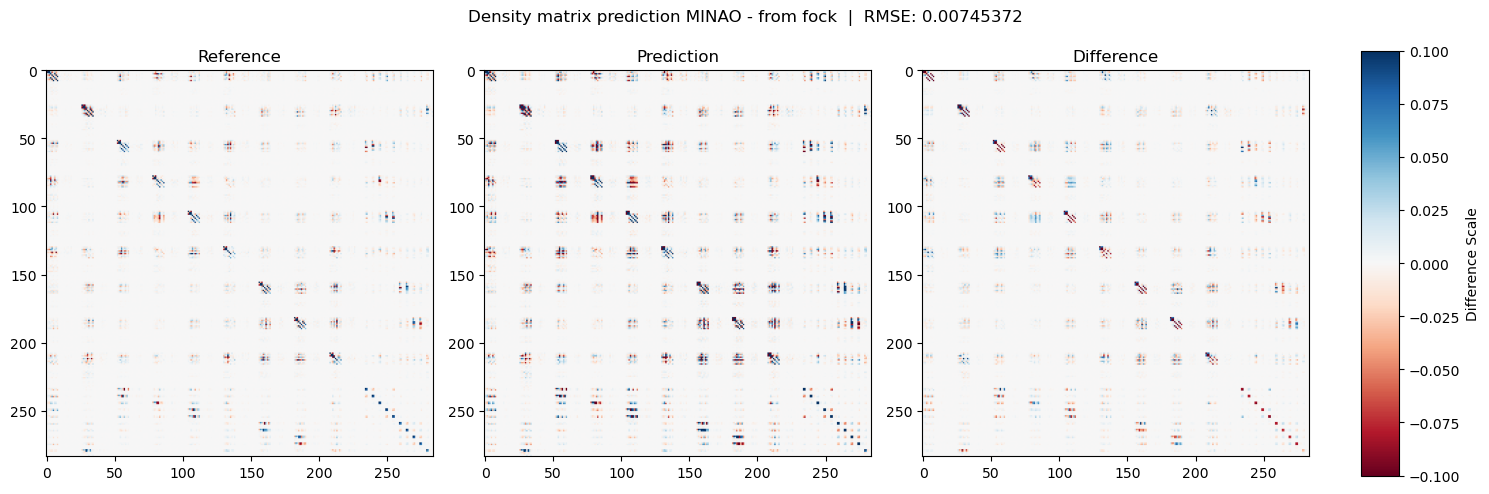

AttributeError: 'numpy.ndarray' object has no attribute 'fock'

In [ ]:
d, e, S, hcore, F = scf_one_iteration_from_minao(test_mol.native)
plot_mat_comp(ground_truth_density, d, title="Density matrix prediction MINAO - from fock", vmax=0.1)
plot_mat_comp(minao_guess.fock().numpy, F, title="minao_fock vs minao_fock", vmax=0.1)
plot_mat_comp(minao_guess.overlap().numpy, S, title="minao_overlap vs minao_overlap", vmax=0.1)
density_from_minao_fock = density_from_fock(minao_guess.fock().numpy, minao_guess.overlap().numpy, test_mol.native.nelectron//2)
plot_mat_comp(ground_truth_density, density_from_minao_fock, title="truth density vs. minao from fock density", vmax=0.1)
